## Capstone project 3 
### Automated Customer Complaint Classification
 
Customer complaints are usually unstructured text data, which traditionally require companies to assign multiple support employees to evaluate and allocate each ticket to the relevant department. As the company grows and acquires a larger customer base, this process becomes tedious. Therefore, the company aims to automate its customer support ticket system. Being a financial company, the firm offers numerous products and services, including credit cards, banking, and mortgages/loans.


#### Problem statement formation 
The task is to build a model that can efficiently classify customer complaints based on the products and services offered by the company. These complaints are unstructured text data, and the company wants to automate the process of evaluating and assigning each ticket to the relevant department.

**Ticket Classification: Develop a model that can accurately categorize customer complaints into one of the following five clusters:**

- Topic 1 = Bank account services
- Topic 2 = Credit card / Prepaid card
- Topic 3 = Others
- Topic 4 = Theft/Dispute reporting
- Topic 5 = Mortgages/loans


### Data wrangling
Imports

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
# from sklearn.metrics import plot_roc_curve
# from pprint import pprint

In [3]:
# Setting max rows and columns
# pd.set_option('max_columns', 50)
# pd.set_option('max_rows', 50)


In [4]:
import warnings
warnings.filterwarnings('ignore', category=SyntaxWarning)

In [5]:
# Opening JSON file 
f = open(r'D:\lalo\capstone-3\Data\complaints.json') 
  
# returns JSON object as a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [6]:
# Explore The Data
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
df.shape

(78313, 22)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [9]:
# Columns name 
col_name = df.columns
col_name

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [10]:
# Assign new column name to dataframe
new_col = [i.split('.')[-1] for i in col_name]

In [11]:
df.columns = new_col

In [12]:
df.head(3)

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided


To achieve our desired outcome, we need to extract information from the 'complaint_what_happened' column. This column likely contains feedback or opinions provided by users or customers. By analyzing this data, we can gather insights and draw conclusions that can help us make informed decisions. Therefore, it is crucial that we effectively obtain and interpret the data from this column.

In [13]:
# find null values
df.isna().sum()

_index                           0
_type                            0
_id                              0
_score                           0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [14]:
df['complaint_what_happened'].head(5)

0                                                     
1    Good morning my name is XXXX XXXX and I apprec...
2    I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                     
4                                                     
Name: complaint_what_happened, dtype: object

The analysis indicates that there are no null values in the 'review' variable. However, we did observe the presence of empty spaces in the variable.

In [15]:
df = df[df['complaint_what_happened'] != '']

In [16]:
df.shape

(21072, 22)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   _index                     21072 non-null  object 
 1   _type                      21072 non-null  object 
 2   _id                        21072 non-null  object 
 3   _score                     21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  object 


The following step involves removing words with numbers, converting text to lowercase, and removing punctuation.

In [18]:
def clean_text(sent):
    sent = sent.lower() # Text to lowercase
    pattern = '[^\w\s]' # Removing punctuation
    clean_sent = re.sub(pattern, '', sent) 
    pattern = '\w*\d \w*' # Removing words with numbers in between
    clean_sent = re.sub(pattern, '', clean_sent) 
    return clean_sent

In [19]:
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))

In [20]:
df_clean['complaint_what_happened'] = df_clean['complaint_what_happened'].str.replace('xxxx','')

In [21]:
df_clean.head()

,complaint_what_happened
1,good morning my name is and i appreciate it ...
2,i upgraded my card in was told by the agent...
10,chase card was reported on fraudulent applica...
11,on trying to book a ticket i came across ...
14,my grand son give me check for deposit it int...


In [22]:
# function to Lemmatize the texts
def lemmmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [23]:
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmmatize_text)

In [24]:
df_clean['complaint_lemmatized'].head()

1     good morning my name be    and I appreciate it...
2     I upgrade my    card in   be tell by the agent...
10    chase card be report on   fraudulent applicati...
11    on   try to book a      ticket I come across a...
14    my grand son give I check for   deposit it int...
Name: complaint_lemmatized, dtype: object

In [25]:
#function to extract the POS tags 
def get_POS_tags(text):
    sent = []
    blob = TextBlob(text)
    sent = [word for (word,tag) in blob.tags if tag=='NN']
    return " ".join(sent)

In [26]:
df_clean['complaint_pos'] = df_clean['complaint_lemmatized'].apply(get_POS_tags)

In [27]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_pos
1,good morning my name is and i appreciate it ...,good morning my name be and I appreciate it...,morning name stop bank cardmember service ask ...
2,i upgraded my card in was told by the agent...,I upgrade my card in be tell by the agent...,card agent upgrade date agent information orde...
10,chase card was reported on fraudulent applica...,chase card be report on fraudulent applicati...,card application identity consent service cred...
11,on trying to book a ticket i came across ...,on try to book a ticket I come across a...,try book ticket offer ticket card information ...
14,my grand son give me check for deposit it int...,my grand son give I check for deposit it int...,son deposit chase account fund bank account pa...


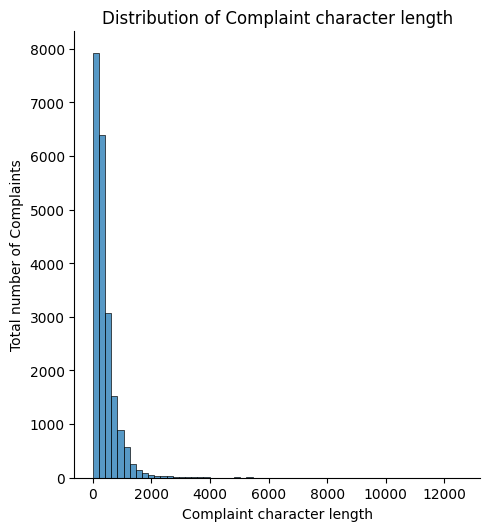

In [28]:
# Visualise the data according to the 'Complaint' character length
char_len = [len(each_sent) for each_sent in df_clean['complaint_pos']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

In [29]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_pos'].str.replace('-PRON-', '')

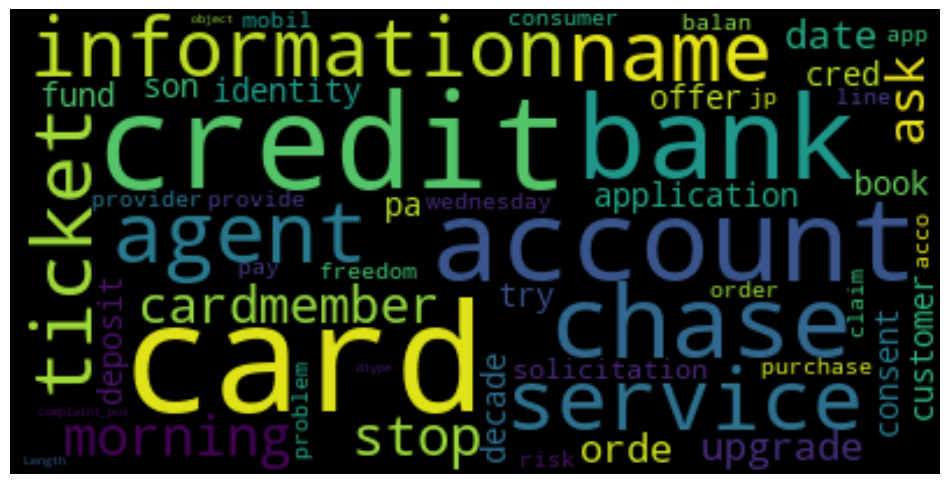

In [30]:
#Using a word cloud find the top 60 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=65, max_words=60, 
                      background_color="black", random_state=100, 
                      stopwords=stopwords).generate(str(df_clean['complaint_pos']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [31]:
# Creating a function to extract top ngrams(unigram/bigram/trigram) based on the function inputs
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [32]:
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,account,47334
1,chase,46153
2,credit,33609
3,card,29104
4,bank,28354
5,payment,20782
6,time,15325
7,charge,14494
8,check,12059
9,money,11942


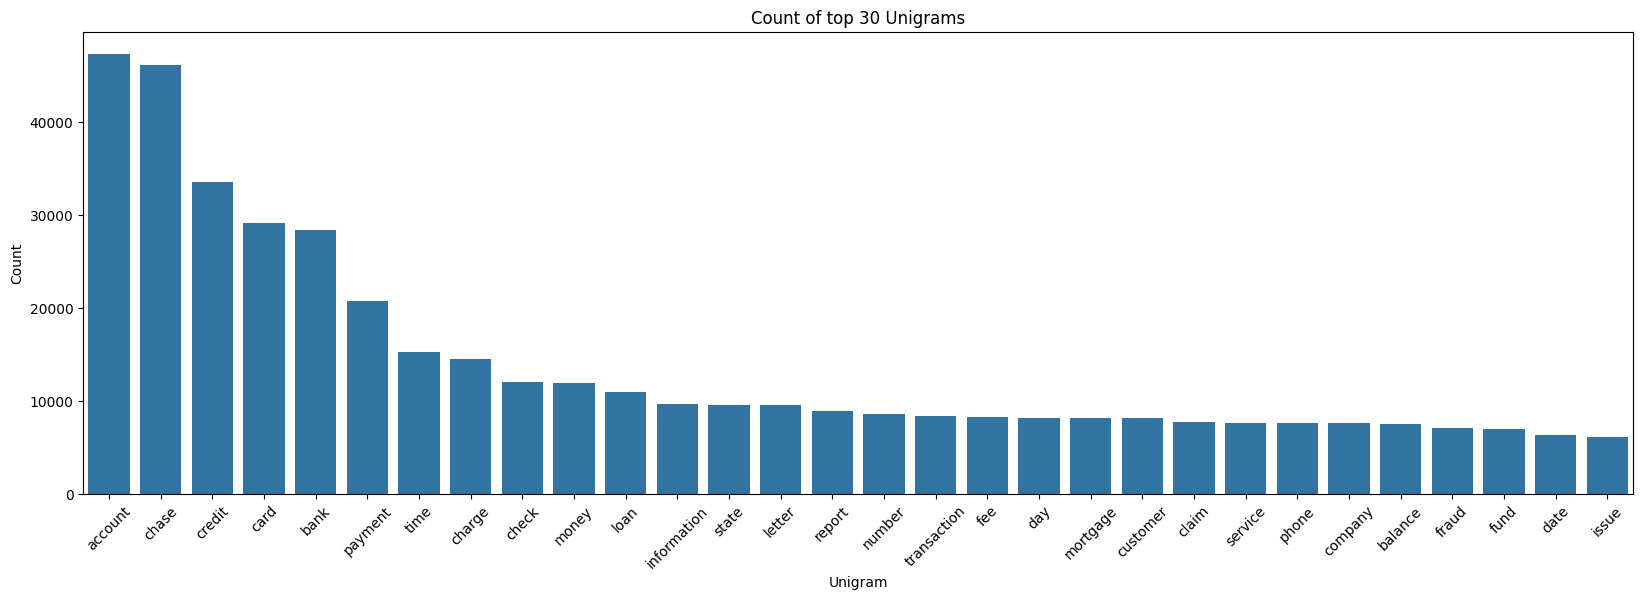

In [33]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [34]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,credit card,12665
1,credit report,3942
2,customer service,3072
3,chase credit,2959
4,chase bank,2949
5,bank account,2765
6,account chase,2735
7,account account,2616
8,chase account,2606
9,check account,2433


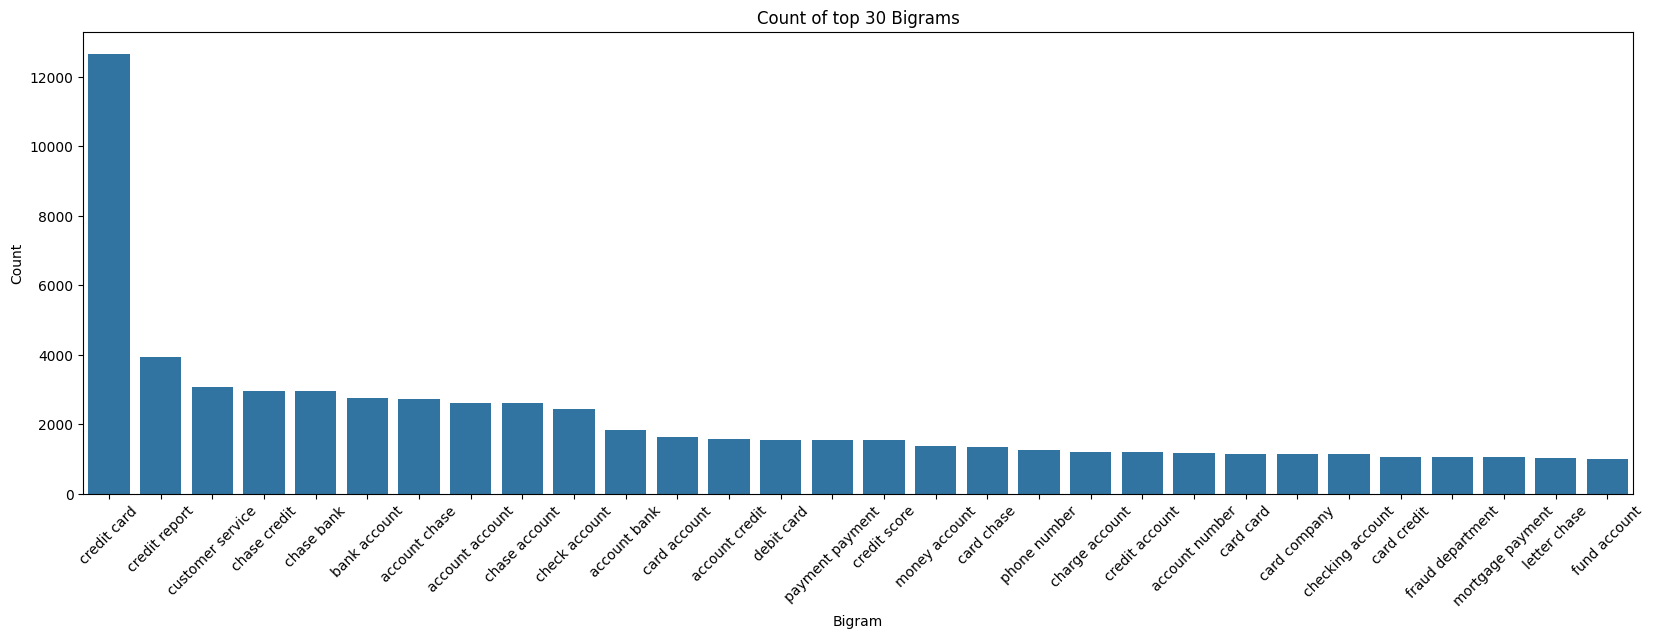

In [35]:
# Plotting top 30 Bigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams")
plt.show()

In [36]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,chase credit card,2045
1,credit card account,1017
2,credit card company,995
3,credit card chase,649
4,credit card credit,534
5,inquiry credit report,482
6,account credit card,416
7,charge credit card,415
8,card credit card,406
9,credit reporting agency,374


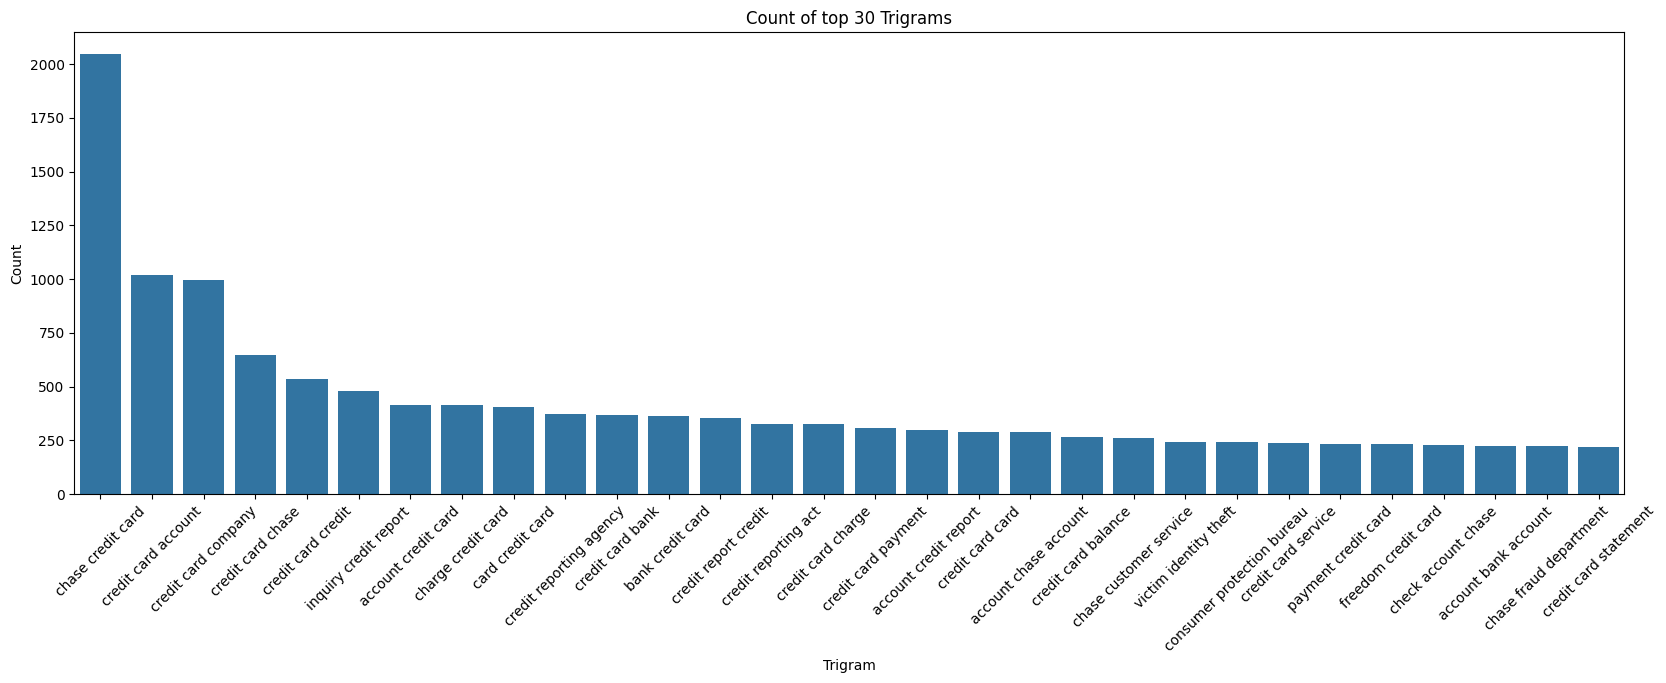

In [37]:
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 30 Trigrams")
plt.show()

In [46]:
df_final = df_clean[['complaint_what_happened','Complaint_clean']]

In [47]:
df_final.head()

,complaint_what_happened,Complaint_clean
1,good morning my name is and i appreciate it ...,morning name stop bank cardmember service ask ...
2,i upgraded my card in was told by the agent...,card agent upgrade date agent information orde...
10,chase card was reported on fraudulent applica...,card application identity consent service cred...
11,on trying to book a ticket i came across ...,try book ticket offer ticket card information ...
14,my grand son give me check for deposit it int...,son deposit chase account fund bank account pa...


In [48]:
df_final.shape

(21072, 2)

To proceed with the next step, it is important to save the current data set. This will ensure that all the necessary information is preserved and readily available for future use.

In [45]:
# Save the data to parquet file
df_final.to_parquet('/Data/df_final.parquet')